In [281]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [282]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

# 0. Load data

In [283]:
# load data
path = 'drive/My Drive/P8/data'
train = pd.read_csv(os.path.join(path, "train_I1.csv"), encoding='utf8', dtype={'text_id': str, 'sentence': str, 'label': str})
val = pd.read_csv(os.path.join(path, "val_I1.csv"), encoding='utf8', dtype={'text_id': str, 'sentence': str, 'label': str})
test = pd.read_csv(os.path.join(path, "test_I1.csv"), encoding='utf8', dtype={'text_id': str, 'sentence': str, 'label': str})

# 1. Basic data exploration

AxesSubplot(0.125,0.125;0.775x0.755)


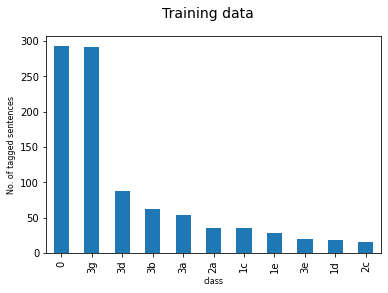

In [284]:
# how many sentences tagged? Class 0 (=not tagged) is undersampled.
fig, ax = plt.subplots()
fig.suptitle('Training data', fontsize=14)
plt.xlabel('class', fontsize=8)
plt.ylabel('No. of tagged sentences', fontsize=8)
print(train['label'].value_counts().plot(ax=ax, kind='bar'))
#print(val['label'].value_counts().plot(ax=ax, kind='bar'))
#print(test['label'].value_counts().plot(ax=ax, kind='bar'))

It is a problem that we have so many classes that we barely have data for...

# 2. Classification


## General classification idea

New idea: Multiple subnets

If we want to keep the classes even and maximize the dataset for each class, we can frame this task as a binary classification task for each class which then later can be combined for a final decision. 
E.g. sentence 1 will be loaded into 11 seperate networks that classify it into 
- cls 1 or other
- cls 2 or other
- cls 3 or other
- ...
- cls 11 or other. 

At the end, the scores can be compared and the sentence will be sorted into the class with the highest percentage score. This might be an advantageous approach if we consider that we can then also incorporate different kinds of preprocessing for each subnet.

In this notebook, I will do some experiments to do the following binary classifications: 
- step 3g/not step 3g (Subnet A)
- step 3b/not step 3b (Subnet B)



## Dataset preparation

- Create subcorpora for binary classification for a specific step
- Transform pd dataframe --> tf dataset
- Embedding

### Some helpful functions

In [285]:
def create_subcorpora(step, train_df, val_df, test_df):
  """Create train, test and val corpora for the specific subnet. 
  This function prepares 3 dataframes for binary classification: 
  new label 1 = the class we want to classify in this subnet. 
  new label 0 = random samples of all other classes, size equal to length of class 1."""
  # get sample length
  n_train = len(train[train['label'] == step])
  n_val = len(val[val['label'] == step])
  n_test = len(test[test['label'] == step])
  # create subset 
  # train: keep all instances of class 5 and 400 random other rows 
  subset_train = pd.concat([
      train[train['label'] == step],  # keep all rows with label 5
      train[train['label'] != step].sample(n=n_train, random_state=42)  # sample 500 rows with other labels
  ]).dropna()
  # val: keep all instances of class 5 and 50 random other rows 
  subset_val = pd.concat([
      val[val['label'] == step],  # keep all rows with label 5
      val[val['label'] != step].sample(n=n_val, random_state=42)  # sample 500 rows with other labels
  ]).dropna()
  # test: keep all instances of class 5 and 50 random other rows
  subset_test = pd.concat([
      test[test['label'] == step],  # keep all rows with label 5
      test[test['label'] != step].sample(n=n_test, random_state=42)  # sample 500 rows with other labels
  ]).dropna()

  # create new label 
  subset_train['new_label'] = [int(1) if x == step else int(0) for x in subset_train["label"]]
  subset_val['new_label'] = [int(1) if x == step else int(0) for x in subset_val["label"]]
  subset_test['new_label'] = [int(1) if x == step else int(0) for x in subset_test["label"]]

  # drop unnecessary columns
  subset_train = subset_train.drop(["text_id", "label"], axis = 1)
  subset_val = subset_val.drop(["text_id", "label"], axis = 1)
  subset_test = subset_test.drop(["text_id", "label"], axis = 1)

  return subset_train, subset_val, subset_test


In [286]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  """pd Dataframe -> tensorflow dataset for baseline model and lstm"""
  dataframe = dataframe.copy()
  labels = dataframe.pop('new_label')
  dataframe = dataframe["sentence"]
  #dataframe = dataframe.apply(lambda x: str(x))
  ds = tf.data.Dataset.from_tensor_slices((dataframe, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [287]:
# prepare function to check for overfitting
# check for overfitting
def plot_result(history):
  plt.plot(history.history['accuracy'], label ="Training accuracy")
  plt.plot(history.history['val_accuracy'], label ="Validation accuracy")
  plt.title("Accuracy of baseline model on step 3g")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()
  return plt

### Dataset for step 3g

In [288]:
# get sub-frames
train_3g, val_3g, test_3g = create_subcorpora("3g", train, val, test)

# create tensorflow datasets from pandas dataframes
train_data_3g = df_to_dataset(train_3g)
val_data_3g = df_to_dataset(val_3g)
test_data_3g = df_to_dataset(test_3g)

### Dataset for step 3b

In [ ]:
# get datasets
train_3b, val_3b, test_3b = create_subcorpora("3b", train, val, test)

# create tensorflow datasets from pandas dataframes
train_data_3b = df_to_dataset(train_3b)
val_data_3b = df_to_dataset(val_3b)
test_data_3b = df_to_dataset(test_3b)

## Build models



### Baseline: Simple Sequential Model

In [ ]:
# embedding
import tensorflow_hub as hub
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-de-dim50/2",
                           dtype=tf.string, trainable=True)

# model
model_bl = tf.keras.Sequential()
model_bl.add(hub_layer) # embedding
model_bl.add(tf.keras.layers.Dense(16, activation='relu'))
model_bl.add(tf.keras.layers.Dropout(0.4))
model_bl.add(tf.keras.layers.Dense(16, activation='relu'))
model_bl.add(tf.keras.layers.Dropout(0.4))
model_bl.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_bl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

### LSTM

In [323]:
# encoder
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data_3b.map(lambda text, label: text)) # todo adapt when training the other dataset

# model
model_lstm = tf.keras.Sequential([
    encoder, 
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ), 
    tf.keras.layers.LSTM(32), 
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

### CNN


In [319]:
embedding_dim = 100

model_cnn = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=embedding_dim,
        #output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_18 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_19 (Embedding)    (None, None, 100)         100000    
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         64128     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_58 (Dense)            (None, 10)                1290      
                                                                 
 dense_59 (Dense)            (None, 1)               

## Subnet A: Step 3g/not step 3g

Binary classification Step 3g/not step 3g



### Baseline: Simple Sequential Model

In [ ]:
# evaluate untrained model on training and validation data
model_bl.evaluate(train_data_3g)
model_bl.evaluate(train_data_3g)

19/19 [==============================] - 0s 2ms/step - loss: 0.6957 - accuracy: 0.5171


[0.695676326751709, 0.517123281955719]

In [277]:
# train model
history_bl_3g = model_bl.fit(train_data_3g, epochs = 6, validation_data=val_data_3g)

Epoch 1/6
19/19 [==============================] - 27s 1s/step - loss: 0.6932 - accuracy: 0.5342 - val_loss: 0.6874 - val_accuracy: 0.5753
Epoch 2/6
19/19 [==============================] - 42s 2s/step - loss: 0.6812 - accuracy: 0.5839 - val_loss: 0.6751 - val_accuracy: 0.6774
Epoch 3/6
19/19 [==============================] - 27s 1s/step - loss: 0.6651 - accuracy: 0.5993 - val_loss: 0.6566 - val_accuracy: 0.7527
Epoch 4/6
19/19 [==============================] - 31s 2s/step - loss: 0.6372 - accuracy: 0.6695 - val_loss: 0.6279 - val_accuracy: 0.8065
Epoch 5/6
19/19 [==============================] - 33s 2s/step - loss: 0.5919 - accuracy: 0.7226 - val_loss: 0.5741 - val_accuracy: 0.8333
Epoch 6/6
19/19 [==============================] - 32s 2s/step - loss: 0.5298 - accuracy: 0.8031 - val_loss: 0.5028 - val_accuracy: 0.8387


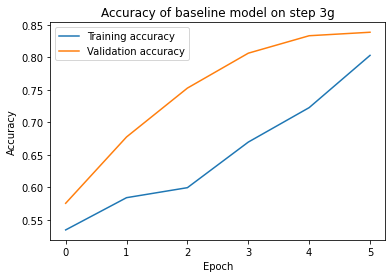

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

In [278]:
# check for overfitting
plot_result(history_bl_3g)

In [279]:
# evaluate on test data
model_bl.evaluate(test_data_3g)

6/6 [==============================] - 1s 179ms/step - loss: 0.4928 - accuracy: 0.8587


[0.49280473589897156, 0.8586956262588501]

### LSTM

In [ ]:
# evaluate untrained model on training and validation data
model_lstm.evaluate(train_data_3g)
model_lstm.evaluate(train_data_3g)

19/19 [==============================] - 0s 6ms/step - loss: 0.0056 - accuracy: 1.0000


[0.005612088833004236, 1.0]

In [ ]:
history_lstm_3g = model_lstm.fit(train_data_3g, epochs = 6, validation_data=val_data_3g)

Epoch 1/6
19/19 [==============================] - 1s 37ms/step - loss: 0.0674 - accuracy: 0.9932 - val_loss: 0.3385 - val_accuracy: 0.9301
Epoch 2/6
19/19 [==============================] - 1s 49ms/step - loss: 0.0494 - accuracy: 0.9949 - val_loss: 0.3679 - val_accuracy: 0.9247
Epoch 3/6
19/19 [==============================] - 1s 46ms/step - loss: 0.0279 - accuracy: 0.9983 - val_loss: 0.3312 - val_accuracy: 0.9301
Epoch 4/6
19/19 [==============================] - 0s 24ms/step - loss: 0.0221 - accuracy: 0.9983 - val_loss: 0.3648 - val_accuracy: 0.9301
Epoch 5/6
19/19 [==============================] - 0s 25ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.3771 - val_accuracy: 0.9355
Epoch 6/6
19/19 [==============================] - 0s 22ms/step - loss: 0.0143 - accuracy: 1.0000 - val_loss: 0.4032 - val_accuracy: 0.9301


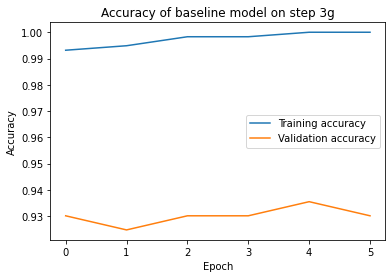

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

In [ ]:
# check for overfitting
plot_result(history_lstm_3g)

In [ ]:
# evaluate on test data
model_lstm.evaluate(test_data_3g)

6/6 [==============================] - 0s 13ms/step - loss: 0.6157 - accuracy: 0.8913


[0.6157464385032654, 0.8913043737411499]

### RNN

In [289]:
for example, label in train_data_3g.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'quantitativ Analyse Bezug Vorkommnis pro Seitenzahl'
 b'Arbeit drei Hauptteil gliedern'
 b'Anschluss erl\xc3\xa4uteren erster Aktionszyklus Untersuchung']

labels:  [0 1 1]


Encoding

In [290]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_data_3g.map(lambda text, label: text))

In [291]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'kapitel', 'arbeit', 'teil', 'ergebnis',
       'theoretisch', 'schüler', 'fragestellung', 'schülerin', 'erster',
       'sowie', 'folgen', 'erläutern', 'lehrperson', 'vorliegend', 'zwei',
       'zweiter', 'theorie', 'vorstellen'], dtype='<U22')

In [292]:
# encoded examples are zero-padded to the longest sequence in the batch
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[402,  63,  53, 947, 617,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [  3,  27, 122,  51,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [208, 742,  10, 505,  20,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]])

In [293]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'quantitativ Analyse Bezug Vorkommnis pro Seitenzahl'
Round-trip:  quantitativ analyse bezug vorkommnis pro [UNK]             

Original:  b'Arbeit drei Hauptteil gliedern'
Round-trip:  arbeit drei hauptteil gliedern               

Original:  b'Anschluss erl\xc3\xa4uteren erster Aktionszyklus Untersuchung'
Round-trip:  anschluss erläuteren erster aktionszyklus untersuchung              



Model

In [294]:
# create model
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [295]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [296]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-0.01309843]


In [297]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [298]:
history = model.fit(train_data_3g, epochs=10,
                    validation_data=test_data_3g,
                    validation_steps=30)

Epoch 1/10
19/19 [==============================] - ETA: 0s - loss: 0.6915 - accuracy: 0.5000

19/19 [==============================] - 15s 324ms/step - loss: 0.6915 - accuracy: 0.5000 - val_loss: 0.6887 - val_accuracy: 0.5000
Epoch 2/10
19/19 [==============================] - 1s 42ms/step - loss: 0.6882 - accuracy: 0.5000
Epoch 3/10
19/19 [==============================] - 1s 41ms/step - loss: 0.6837 - accuracy: 0.5000
Epoch 4/10
19/19 [==============================] - 1s 40ms/step - loss: 0.6771 - accuracy: 0.5000
Epoch 5/10
19/19 [==============================] - 1s 43ms/step - loss: 0.6663 - accuracy: 0.5000
Epoch 6/10
19/19 [==============================] - 1s 41ms/step - loss: 0.6494 - accuracy: 0.5000
Epoch 7/10
19/19 [==============================] - 1s 41ms/step - loss: 0.6207 - accuracy: 0.5000
Epoch 8/10
19/19 [==============================] - 1s 42ms/step - loss: 0.5752 - accuracy: 0.5154
Epoch 9/10
19/19 [==============================] - 1s 42ms/step - loss: 0.5046 - accuracy: 0.6421
Epoch 10/10
19/19 [==============================] - 1s 39ms/step - loss: 0.

In [299]:
test_loss, test_acc = model.evaluate(test_data_3g)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

6/6 [==============================] - 0s 12ms/step - loss: 0.4070 - accuracy: 0.8152
Test Loss: 0.40700945258140564
Test Accuracy: 0.8152173757553101


### CNN

In [320]:
history_cnn_3g = model_cnn.fit(train_data_3g, epochs=6, validation_data=val_data_3g)

Epoch 1/6
19/19 [==============================] - 2s 26ms/step - loss: 0.6804 - accuracy: 0.6113 - val_loss: 0.6334 - val_accuracy: 0.7527
Epoch 2/6
19/19 [==============================] - 1s 44ms/step - loss: 0.5745 - accuracy: 0.8476 - val_loss: 0.4872 - val_accuracy: 0.8548
Epoch 3/6
19/19 [==============================] - 1s 46ms/step - loss: 0.3572 - accuracy: 0.9538 - val_loss: 0.2929 - val_accuracy: 0.8871
Epoch 4/6
19/19 [==============================] - 0s 24ms/step - loss: 0.1554 - accuracy: 0.9675 - val_loss: 0.2080 - val_accuracy: 0.9032
Epoch 5/6
19/19 [==============================] - 0s 24ms/step - loss: 0.0683 - accuracy: 0.9829 - val_loss: 0.2144 - val_accuracy: 0.8978
Epoch 6/6
19/19 [==============================] - 0s 23ms/step - loss: 0.0359 - accuracy: 0.9949 - val_loss: 0.2277 - val_accuracy: 0.8978


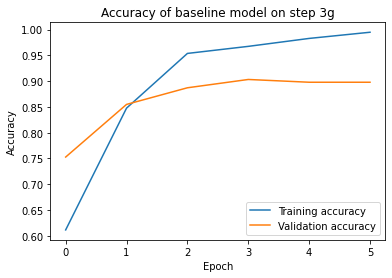

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

In [322]:
# check for overfitting
plot_result(history_cnn_3g)

In [321]:
# evaluate on test data
model_cnn.evaluate(test_data_3g)

6/6 [==============================] - 0s 6ms/step - loss: 0.2485 - accuracy: 0.9239


[0.24853837490081787, 0.9239130616188049]

## Subnet B: Step 3b/not step 3b
Binary classification Step 3b/not step 3b


### Baseline: simple Sequential Model

In [ ]:
# evaluate untrained model on training and validation data
model_bl.evaluate(train_data_3b)
model_bl.evaluate(train_data_3b)

4/4 [==============================] - 1s 170ms/step - loss: 0.0628 - accuracy: 1.0000


[0.06277505308389664, 1.0]

In [ ]:
# train model
history_bl_3b = model_bl.fit(train_data_3b, epochs = 6, validation_data=val_data_3b)

Epoch 1/6
4/4 [==============================] - 10s 3s/step - loss: 0.1167 - accuracy: 0.9841 - val_loss: 0.5172 - val_accuracy: 0.6897
Epoch 2/6
4/4 [==============================] - 5s 1s/step - loss: 0.1144 - accuracy: 0.9841 - val_loss: 0.5156 - val_accuracy: 0.6897
Epoch 3/6
4/4 [==============================] - 6s 2s/step - loss: 0.0840 - accuracy: 0.9841 - val_loss: 0.5166 - val_accuracy: 0.6897
Epoch 4/6
4/4 [==============================] - 7s 2s/step - loss: 0.0980 - accuracy: 0.9841 - val_loss: 0.5196 - val_accuracy: 0.6897
Epoch 5/6
4/4 [==============================] - 5s 1s/step - loss: 0.0954 - accuracy: 0.9841 - val_loss: 0.5235 - val_accuracy: 0.6897
Epoch 6/6
4/4 [==============================] - 6s 2s/step - loss: 0.0636 - accuracy: 0.9921 - val_loss: 0.5284 - val_accuracy: 0.6897


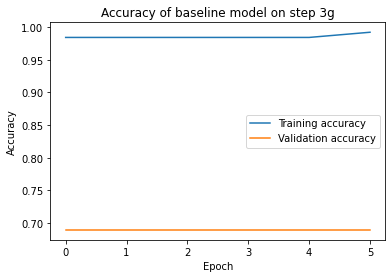

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

In [ ]:
# check for overfitting
plot_result(history_bl_3b)

In [ ]:
# evaluate on test data
model_bl.evaluate(test_data_3b)

2/2 [==============================] - 0s 174ms/step - loss: 0.6762 - accuracy: 0.6875


[0.6761987805366516, 0.6875]

### LSTM

TODO: Adapt encoder above if necessary

In [326]:
# evaluate untrained model on training and validation data
model_lstm.evaluate(train_data_3b)
model_lstm.evaluate(val_data_3b)

2/2 [==============================] - 0s 22ms/step - loss: 0.6933 - accuracy: 0.5345


[0.6933080554008484, 0.5344827771186829]

In [327]:
# train model
history_lstm_3b = model_bl.fit(train_data_3b, epochs = 6, validation_data=val_data_3b)

Epoch 1/6
4/4 [==============================] - 7s 2s/step - loss: 0.8589 - accuracy: 0.4048 - val_loss: 0.7288 - val_accuracy: 0.5517
Epoch 2/6
4/4 [==============================] - 6s 2s/step - loss: 0.7730 - accuracy: 0.4127 - val_loss: 0.7141 - val_accuracy: 0.5345
Epoch 3/6
4/4 [==============================] - 6s 1s/step - loss: 0.7722 - accuracy: 0.5159 - val_loss: 0.7020 - val_accuracy: 0.5345
Epoch 4/6
4/4 [==============================] - 5s 1s/step - loss: 0.6753 - accuracy: 0.5794 - val_loss: 0.6922 - val_accuracy: 0.5690
Epoch 5/6
4/4 [==============================] - 6s 2s/step - loss: 0.6264 - accuracy: 0.6349 - val_loss: 0.6844 - val_accuracy: 0.5690
Epoch 6/6
4/4 [==============================] - 6s 2s/step - loss: 0.6240 - accuracy: 0.6746 - val_loss: 0.6776 - val_accuracy: 0.5690


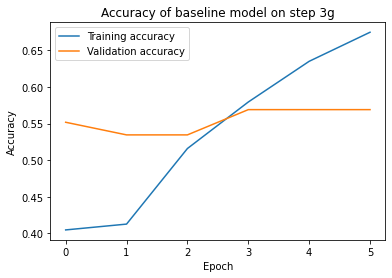

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

In [328]:
# check for overfitting
plot_result(history_lstm_3b)

In [329]:
# evaluate on test data
model_lstm.evaluate(test_data_3b)

2/2 [==============================] - 0s 13ms/step - loss: 0.6933 - accuracy: 0.4844


[0.6933112740516663, 0.484375]

### CNN

In [330]:
history_cnn_3b = model_cnn.fit(train_data_3b, epochs=6, validation_data=val_data_3b)

Epoch 1/6
4/4 [==============================] - 0s 43ms/step - loss: 3.0495 - accuracy: 0.3413 - val_loss: 1.5734 - val_accuracy: 0.3793
Epoch 2/6
4/4 [==============================] - 0s 23ms/step - loss: 1.8118 - accuracy: 0.4206 - val_loss: 1.0360 - val_accuracy: 0.5517
Epoch 3/6
4/4 [==============================] - 0s 34ms/step - loss: 1.1786 - accuracy: 0.5794 - val_loss: 1.1952 - val_accuracy: 0.5000
Epoch 4/6
4/4 [==============================] - 0s 31ms/step - loss: 0.9246 - accuracy: 0.6032 - val_loss: 0.9555 - val_accuracy: 0.5172
Epoch 5/6
4/4 [==============================] - 0s 24ms/step - loss: 0.6481 - accuracy: 0.7063 - val_loss: 0.7731 - val_accuracy: 0.6207
Epoch 6/6
4/4 [==============================] - 0s 46ms/step - loss: 0.5071 - accuracy: 0.7857 - val_loss: 0.6708 - val_accuracy: 0.6034


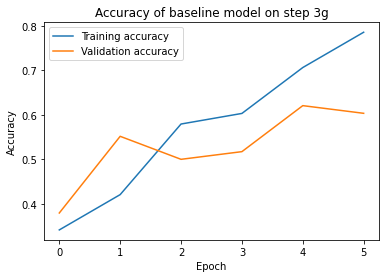

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

In [333]:
# check for overfitting
plot_result(history_cnn_3b)

In [334]:
# evaluate on test data
model_cnn.evaluate(test_data_3g)

6/6 [==============================] - 0s 9ms/step - loss: 0.5398 - accuracy: 0.7065


[0.5397834777832031, 0.70652174949646]

---------------------------------------------------------------------------------
